In [1]:
import gymnasium as gym
from stable_baselines3 import DDPG, HerReplayBuffer, SAC
from stable_baselines3.common.callbacks import BaseCallback, CallbackList
import panda_gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class CumulativeRewardCallback(BaseCallback):
    def __init__(self):
        super(CumulativeRewardCallback, self).__init__()
        self.all_trial_rewards = []
        self.current_trial_rewards = []

    def _on_step(self) -> bool:
        # Check if a new episode has started
        if self.locals.get("infos"):
            for info in self.locals["infos"]:
                if "episode" in info.keys():
                    # Extract the episode reward and append it to the list
                    episode_reward = info["episode"]["r"]
                    self.current_trial_rewards.append(episode_reward)
        return True
    
    def on_training_end(self):
    # Store cumulative rewards for the trial
        self.all_trial_rewards.append(np.cumsum(self.current_trial_rewards))
        self.current_trial_rewards = []

    def get_all_trial_rewards(self):
        return self.all_trial_rewards
    
    from stable_baselines3.common.callbacks import BaseCallback


class EpisodeCountCallback(BaseCallback):
    def __init__(self):
        super(EpisodeCountCallback, self).__init__()
        self.episode_count = 0

    def _on_step(self) -> bool:
        # Increment episode count if a new episode is logged
        if self.locals.get("infos"):
            for info in self.locals["infos"]:
                if "episode" in info.keys():
                    self.episode_count += 1
        return True

    def get_episode_count(self):
        return self.episode_count



Stable-Baselines3 DDPG 

In [ ]:
# Number of trials and episodes

num_trials = 10
timesteps = 100_000

# Create a list to store rewards for all trials
all_rewards = []
episodes_per_trial = []
all_episodes = []

for trial in range(num_trials):

    " CHANGE BASED ON DESIRED ENVIRONMENT "
    # environments
    env = gym.make("PandaReach-v3")
    #env = gym.make("PandaPush-v3")
    #env = gym.make("PandaSlide-v3")
    #env = gym.make("PandaPickAndPlace-v3")
    #env = gym.make("PandaStack-v3")
    #env = gym.make("PandaFlip-v3")

    # stable-baselines3 DDPG Algorithm 
    """ DDPG """
    model = DDPG(policy = "MultiInputPolicy", env = env, replay_buffer_class=HerReplayBuffer, verbose=1)

    # store cumulative rewards from reward callback class
    cumulative_reward_callback = CumulativeRewardCallback()

    # store episodes from episode callback class
    episode_count_callback = EpisodeCountCallback()

    # Combine them into a CallbackList
    callback_list = CallbackList([cumulative_reward_callback, episode_count_callback])

    # Train Model
    model.learn(total_timesteps = timesteps, callback = callback_list )

    # close the environment once training is done
    env.close()

    # Store rewards and episodes for each trial
    trial_rewards = np.array(cumulative_reward_callback.get_all_trial_rewards()).flatten()
    total_episodes = episode_count_callback.get_episode_count()

    # all rewards
    all_rewards.append(trial_rewards)  
    # Store all episodes
    episodes_per_trial.append(total_episodes)
    all_episodes.append(list(range(1, total_episodes + 1)))

# Final Debug
# print(f"All Rewards: {all_rewards}")
# print(f"Episodes per Trial: {episodes_per_trial}")
# print(f"All Episodes: {all_episodes}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.2     |
|    ep_rew_mean     | -41      |
|    success_rate    | 0.25     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 64       |
|    time_elapsed    | 2        |
|    total_timesteps | 165      |
| train/             |          |
|    actor_loss      | 0.789    |
|    critic_loss     | 0.176    |
|    learning_rate   | 0.001    |
|    n_updates       | 64       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.6     |
|    ep_rew_mean     | -45.5    |
|    success_rate    | 0.125    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 46       |
|    time_elapsed    | 7        |
|    total_timesteps | 365      |
| train/             

Stable-Baselines3 DDPG Plot

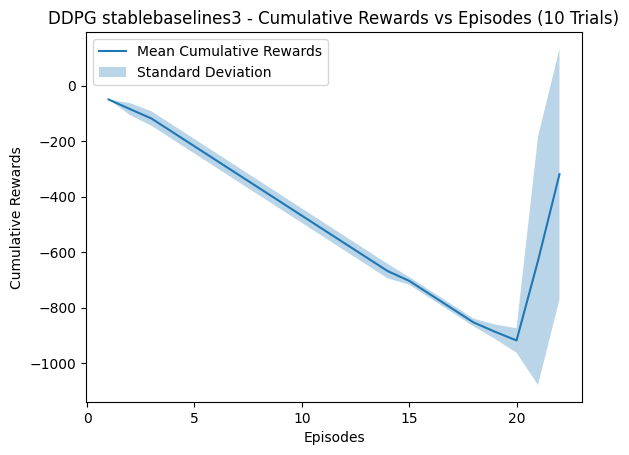

In [ ]:
# Flatten all_rewards
all_rewards = [np.array(trial) for trial in all_rewards if len(trial) > 0]

# Debug
# for i, trial in enumerate(all_rewards):
#     print(f"Trial {i}: Type = {type(trial)}, Length = {len(trial)}, Content = {trial}")

# make sure trials are the same length
max_length = max(len(trial) for trial in all_rewards)
padded_rewards = np.zeros((num_trials, max_length))

for i, trial in enumerate(all_rewards):
    padded_rewards[i, :len(trial)] = trial

# Compute mean and standard deviation across trials
mean_cumulative_rewards = np.mean(padded_rewards, axis=0)
std_cumulative_rewards = np.std(padded_rewards, axis=0)

# Define episodes as a range from 1 to the maximum length of trials (inclusive)
episodes = np.arange(1, max_length + 1)

# Plot mean cumulative rewards
plt.plot(episodes, mean_cumulative_rewards, label='DDPG stablebaselines3')

# Plot confidence interval
plt.fill_between(
    episodes,
    mean_cumulative_rewards - std_cumulative_rewards,
    mean_cumulative_rewards + std_cumulative_rewards,
    alpha=0.3,
    #label='Standard Deviation',
)

plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.title('PandaReach-v3 Cumulative Rewards vs Episodes (10 Trials)')
plt.legend()
plt.show()


Stable-Baselines3 SAC Algorithm

In [ ]:
# Number of trials and episodes
num_trials = 10
timesteps = 100_000

# Create a list to store rewards for all trials
all_rewards = []

for trial in range(num_trials):

    " CHANGE BASED ON DESIRED ENVIRONMENT "
    # environments
    env = gym.make("PandaReach-v3")
    #env = gym.make("PandaPush-v3")
    #env = gym.make("PandaSlide-v3")
    #env = gym.make("PandaPickAndPlace-v3")
    #env = gym.make("PandaStack-v3")
    #env = gym.make("PandaFlip-v3")

    """ SAC """
    # stable-baselines3 DDPG Algorithm 
    model = SAC(policy="MultiInputPolicy", env=env, replay_buffer_class=HerReplayBuffer, verbose=1)

    # store cumulative rewards from reward callback class
    cumulative_reward_callback = CumulativeRewardCallback()

    # Train Model
    model.learn(total_timesteps = timesteps, callback = cumulative_reward_callback)

    # close the environment once training is done
    env.close()

    # Store rewards and episodes for each trial
    trial_rewards = np.array(cumulative_reward_callback.get_all_trial_rewards()).flatten()
    total_episodes = episode_count_callback.get_episode_count()

    # # Debug
    # print(f"Trial {trial}: Total Episodes = {total_episodes}")
    # print(f"Trial {trial}: Rewards = {trial_rewards}")
    # print(f"Trial {trial}: Episodes = {list(range(1, total_episodes + 1))}")

    # all rewards
    all_rewards.append(trial_rewards)  
    # Store all episodes
    episodes_per_trial.append(total_episodes)
    all_episodes.append(list(range(1, total_episodes + 1)))

# Final Debug
# print(f"All Rewards: {all_rewards}")
# print(f"Episodes per Trial: {episodes_per_trial}")
# print(f"All Episodes: {all_episodes}")


SAC Cumulative Rewards vs episodes 10 trials

In [ ]:
# Flatten all_rewards
all_rewards = [np.array(trial) for trial in all_rewards]

# make sure trials are the same length
max_length = max(len(trial) for trial in all_rewards)
padded_rewards = np.zeros((num_trials, max_length))

for i, trial in enumerate(all_rewards):
    padded_rewards[i, :len(trial)] = trial

# Compute mean and standard deviation across trials
mean_cumulative_rewards = np.mean(padded_rewards, axis=0)
std_cumulative_rewards = np.std(padded_rewards, axis=0)

# Define episodes as a range from 1 to the maximum length of trials (inclusive)
episodes = np.arange(1, max_length + 1)

#  Plot mean cumulative rewards
plt.plot(episodes, mean_cumulative_rewards, label='Mean Cumulative Rewards')

# Plot confidence interval
plt.fill_between(
    episodes,
    mean_cumulative_rewards - std_cumulative_rewards,
    mean_cumulative_rewards + std_cumulative_rewards,
    alpha=0.3,
    label='Standard Deviation',
)

plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.title('SAC stablebaselines3 - Cumulative Rewards vs Episodes (10 Trials)')
plt.legend()
plt.show()